In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt
/kaggle/input/flickr8kimagescaptions/flickr8k/images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/3097776588_312932e438.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/1319634306_816f21677f.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/2949337912_beba55698

In [2]:
!pip install torchviz

In [3]:
!pip install --upgrade nltk

In [4]:
!pip install torchsummary

In [5]:
!pip install tensorboard

In [6]:
import os
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import transforms
from torchvision.models import resnet50,ResNet50_Weights
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from collections import defaultdict,Counter
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import random
from textwrap import wrap

In [7]:
# to make sure the results are reproducible
torch.manual_seed(0)
random.seed(42)


In [8]:
df=pd.read_csv("/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt")
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [9]:
def read_image(path,img_size=224):
      transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()])
      img = Image.open(path).convert('RGB')
      img = transform(img)
      return img.permute(1, 2, 0).numpy()

In [10]:
def display_image(temp_df):
    temp_df=temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(5):  # Display 15 images
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        
        # Load and display the image
        image_path = f"/kaggle/input/flickr8kimagescaptions/flickr8k/images/{temp_df.image[i]}"
        image = read_image(image_path)
        plt.imshow(image)
        
        # Display the caption
        caption = "\n".join(wrap(temp_df.caption[i], 20))  # Wrap text for better display
        plt.title(caption)
        plt.axis("off")  # Turn off axis
    
    plt.show()

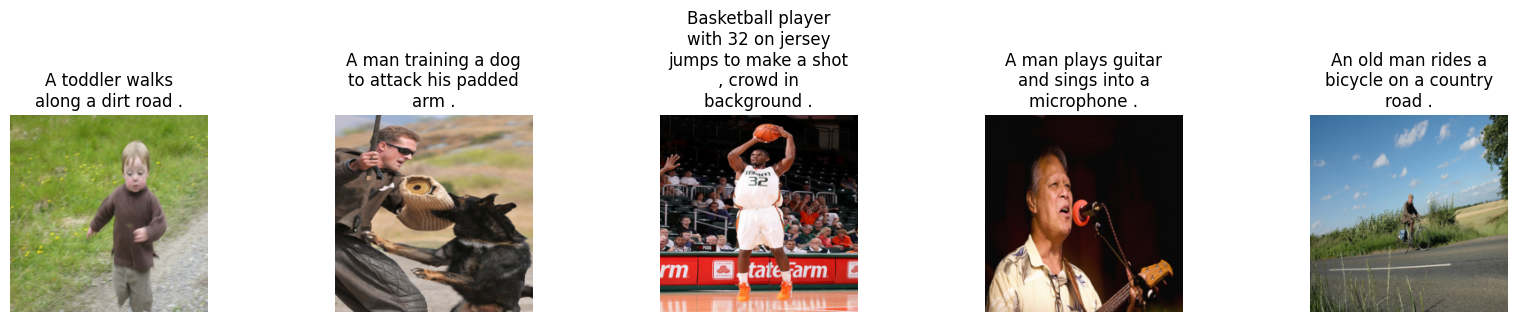

In [11]:
display_image(df.sample(5))

# Data Preprocessing

In [12]:
image_captions = defaultdict(list)
for idx, row in df.iterrows():
    image_captions[row['image']].append(row['caption'])


In [13]:
def tokenize(text):
    # Convert text to lowercase
    text = text.lower()
    # Use regular expressions to extract words (alphanumeric characters)
    tokens = re.findall(r'\w+', text)
    return tokens

In [14]:
tokenize("Sudhanva Is 1111 @ the greatest of all time")

['sudhanva', 'is', '1111', 'the', 'greatest', 'of', 'all', 'time']

In [15]:
all_captions = []
for captions in image_captions.values():
    all_captions.extend(captions)

In [16]:
all_words = []
for caption in all_captions:
    tokens = tokenize(caption)
    all_words.extend(tokens)

In [17]:
all_words[0:10]

['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a']

In [18]:
all_captions[0:10]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [19]:
word_counts = Counter(all_words)
word_counts["girl"]

3328

In [20]:
special_tokens = ['<pad>', '<start>', '<end>', '<unk>']
# Create mappings from words to indices and vice versa
word2idx = {token: idx for idx, token in enumerate(special_tokens)}
idx2word = {idx: token for idx, token in enumerate(special_tokens)}

In [21]:
word2idx

{'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}

In [22]:
idx2word

{0: '<pad>', 1: '<start>', 2: '<end>', 3: '<unk>'}

In [23]:
vocab_size = 10000 # we have set it as the max limit inluding the special tokens
most_common = word_counts.most_common(vocab_size - len(special_tokens))

In [24]:
start_idx=1

In [25]:
most_common[0:10]

[('a', 62992),
 ('in', 18986),
 ('the', 18419),
 ('on', 10745),
 ('is', 9345),
 ('and', 8862),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7274),
 ('of', 6723)]

In [26]:
len(most_common)

8488

In [27]:
# we are starting after the length of start tokens
for idx, (word, _) in enumerate(most_common, start=len(special_tokens)):
    word2idx[word] = idx
    idx2word[idx] = word

In [28]:
word2idx["a"]

4

In [29]:
captions_seqs = {}
max_length = 0  # Keep track of the maximum caption length
for img_name, captions in image_captions.items():
    seqs = []
    for caption in captions:
        # Tokenize the caption and add <start> and <end> tokens
        tokens = ['<start>'] + tokenize(caption) + ['<end>']
        # Convert tokens to indices, use <unk> index if word not in vocabulary
        seq = [word2idx.get(token, word2idx['<unk>']) for token in tokens]
        seqs.append(seq)
        # Update the maximum caption length
        max_length = max(max_length, len(seq))
    captions_seqs[img_name] = seqs

In [30]:
# so now we have a dictionary with image as key and indices of words in captions as keys so the values is a list of lists
captions_seqs["1000268201_693b08cb0e.jpg"]

[[1, 4, 44, 5, 4, 91, 173, 8, 120, 52, 4, 394, 13, 395, 5, 29, 5156, 671, 2],
 [1, 4, 20, 317, 65, 4, 197, 118, 2],
 [1, 4, 41, 20, 120, 65, 4, 197, 2438, 2],
 [1, 4, 41, 20, 120, 6, 395, 21, 61, 2438, 2],
 [1, 4, 41, 20, 5, 4, 91, 173, 317, 65, 4, 197, 2982, 2]]

# Image Transformation for Preprocessing

In [31]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # mean
                         (0.229, 0.224, 0.225))  # std
])

# Dataloader setup

In [32]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, image_ids, captions_seqs, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            image_ids (list): List of image filenames.
            captions_seqs (dict): Dictionary mapping image filenames to sequences of word indices.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.captions = []
        # Prepare the list of image and caption pairs
        for img_id in image_ids:
            captions = captions_seqs[img_id]
            for caption_seq in captions:
                self.images.append(img_id)
                self.captions.append(caption_seq)
    def __len__(self):
        # Return the total number of samples
        return len(self.images)
    def __getitem__(self, idx):
        # Get the image filename and caption sequence at the given index
        img_id = self.images[idx]
        caption_seq = self.captions[idx]
        # Load the image from the directory
        img_path = os.path.join(self.image_dir, img_id)
        image = Image.open(img_path).convert('RGB')

        # Apply the transformations if any
        if self.transform:
            image = self.transform(image)

        # Convert the caption sequence to a tensor
        caption_seq = torch.tensor(caption_seq)
        return image, caption_seq


In [33]:
def collate_fn(data):
    """
    Creates mini-batch tensors from the list of tuples (image, caption).
    We sort the captions by length to use pack_padded_sequence.
    """
    # Sort data by caption length in descending order
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Stack images into a tensor of shape (batch_size, 3, H, W)
    images = torch.stack(images, 0)
    # Get the lengths of each caption
    lengths = [len(cap) for cap in captions]
    # Create a tensor to hold the padded captions
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        # Copy the caption into the targets tensor
        targets[i, :end] = cap[:end]

    return images, targets, lengths

In [34]:
image_dir = '/kaggle/input/flickr8kimagescaptions/flickr8k/images'
image_names = list(image_captions.keys())

In [35]:
train_images, temp_images = train_test_split(image_names, test_size=0.3, random_state=42)

In [36]:

val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)


In [37]:
train_dataset = Flickr8kDataset(image_dir, train_images, captions_seqs, transform)
val_dataset   = Flickr8kDataset(image_dir, val_images, captions_seqs, transform)
test_dataset  = Flickr8kDataset(image_dir, test_images, captions_seqs, transform)

In [38]:
batch_size = 32  # Define the batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

# Model

In [39]:
# let us define the encoder class
import torchvision.models as models
class EncoderCNN(nn.Module):
    def __init__(self, hidden_size):
        """
        Initialize the Encoder CNN using a pre-trained ResNet with BatchNorm
        
        Args:
            hidden_size (int): Dimension of the output feature vector
        """
        super(EncoderCNN, self).__init__()
        
        # Load pre-trained ResNet model (you can choose different variants like resnet50, resnet101)
        resnet = models.resnet50(pretrained=True)
        
        # Remove the last fully connected layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # Freeze the parameters of the pre-trained ResNet
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Add a custom linear layer to map to hidden_size
        self.adaptive_pool = nn.AdaptiveAvgPool2d(1)  # Reduce spatial dimensions to 1x1
        
        # Create a sequential block with linear layer and batch normalization
        self.feature_mapper = nn.Sequential(
            nn.Linear(resnet.fc.in_features, hidden_size),
            nn.BatchNorm1d(hidden_size)
        )
        
    def forward(self, images):
        """
        Forward pass of the Encoder CNN
        
        Args:
            images (torch.Tensor): Input images of shape (batch_size, 3, height, width)
        
        Returns:
            torch.Tensor: Image features of shape (batch_size, hidden_size)
        """
        # Extract features using the modified ResNet
        with torch.no_grad():
            features = self.resnet(images)
        
        # Apply adaptive pooling to reduce spatial dimensions
        features = self.adaptive_pool(features)
        
        # Flatten the features
        features = features.view(features.size(0), -1)
        
        # Pass through the feature mapper (linear + batch norm)
        image_features = self.feature_mapper(features)
        
        return image_features

In [40]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, feature_size, embed_size, num_layers=2, dropout=0.5):
        """
        Decoder RNN for image captioning.

        Args:
            vocab_size: Size of the vocabulary.
            hidden_size: Size of the LSTM hidden state.
            feature_size: Size of the image feature vector.
            embed_size: Size of the word embeddings.
            num_layers: Number of LSTM layers.
            dropout: Dropout rate applied to the embeddings and LSTM layers.
        """
        super(DecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.feature_size = feature_size
        self.num_layers = num_layers

        # Embedding layer for words
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        
        # LSTM layers
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # Fully connected layer to combine image features and LSTM output
        self.fc = nn.Linear(hidden_size + feature_size, vocab_size)
        
        # Softmax layer for output probabilities
        self.softmax = nn.Softmax(dim=-1)
        
        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """
        Initialize weights using Xavier initialization.
        """
        for name, param in self.named_parameters():
            if 'weight' in name:
                if param.dim() > 1:  # Only apply Xavier to 2D+ tensors
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def init_hidden_cell(self, batch_size, device):
        """
        Initialize hidden and cell states to zeros.

        Args:
            batch_size: Number of samples in the batch.
            device: The device on which to create the tensors.

        Returns:
            hidden: Zero-initialized hidden state tensor.
            cell: Zero-initialized cell state tensor.
        """
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return hidden, cell
        
    def forward(self, inputs, features, hidden, cell):
        """
        Forward pass through the Decoder.
        Args:
            inputs: Input word indices of shape [batch_size, seq_len]
            features: Image features of shape [batch_size, feature_size]
            hidden: Previous hidden state of shape [num_layers, batch_size, hidden_size]
                cell: Previous cell state of shape [num_layers, batch_size, hidden_size]
            Returns:
                outputs: Predicted word logits of shape [batch_size, seq_len, vocab_size]
                hidden: Updated hidden state
                cell: Updated cell state
            """
        # Embed the input words and apply dropout
        embeddings = self.dropout(self.embedding(inputs))  # [batch_size, seq_len, embed_size]
        
        # Expand features to match sequence length
        batch_size, seq_len = inputs.shape
        features = features.unsqueeze(1).expand(-1, seq_len, -1)  # [batch_size, seq_len, feature_size]
        
        # Pass through LSTM
        lstm_out, (hidden, cell) = self.lstm(embeddings, (hidden, cell))  # [batch_size, seq_len, hidden_size]
        
        # Concatenate LSTM output with image features for each time step
        combined = torch.cat((lstm_out, features), dim=-1)  # [batch_size, seq_len, hidden_size + feature_size]
        
        # Pass through the fully connected layer
        logits = self.fc(combined)  # [batch_size, seq_len, vocab_size]
        
        return logits, hidden, cell

# Hyperparameters,Loss Function and Optimizers

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Hyperparameters
num_epochs = 10  # Number of epochs for training
embed_size = 256  # Embedding size
hidden_size = 512  # Hidden size of the LSTM
vocab_size = len(word2idx)  # Vocabulary size

Using device: cuda


In [42]:
encoder = EncoderCNN(hidden_size).to(device)
decoder = DecoderRNN(vocab_size,hidden_size,hidden_size,embed_size,num_layers=2,dropout=0.5).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
# Define the loss function (ignore padding index)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])

# Define the optimizer (train both encoder and decoder)
# Use different learning rates for different parameter groups
optimizer = optim.Adam([
    {'params': decoder.parameters()},  # Decoder parameters
    {'params': encoder.feature_mapper.parameters()},  # Encoder feature mapper (linear + batch norm)
], lr=1e-4, weight_decay=1e-4)
# Learning rate scheduler to reduce LR after certain epochs
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training

In [44]:
def prepare_image2captions(image_ids, captions_seqs, idx2word):
    """
    Prepare a dictionary mapping image IDs to lists of reference captions (each as a list of tokens).
    """
    image2captions = {}
    for img_id in image_ids:
        seqs = captions_seqs[img_id]
        captions_list = []
        for seq in seqs:
            # Convert word indices to words
            caption = [idx2word.get(idx, '<unk>') for idx in seq]
            # Remove special tokens
            caption = [word for word in caption if word not in ['<start>', '<end>', '<pad>']]
            captions_list.append(caption) 
        image2captions[img_id] = captions_list
    return image2captions

In [45]:
# Prepare validation and test image-to-captions mappings
val_image2captions = prepare_image2captions(val_images, captions_seqs, idx2word)
test_image2captions = prepare_image2captions(test_images, captions_seqs, idx2word)

In [46]:
def generate_caption_ids(decoder, features, max_length=50):
    """
    Generate a caption for an image given the extracted features.

    Args:
        decoder: The DecoderRNN model.
        features: Image features extracted by the encoder (shape: [batch_size=1, feature_size]).
        max_length: Maximum length of the generated caption.

    Returns:
        sampled_ids: A list of word indices representing the generated caption.
    """
    # Initialize required variables
    start_idx = word2idx['<start>']
    end_idx = word2idx['<end>']
    device = features.device

    # Initialize hidden and cell states (batch size = 1)
    batch_size = features.shape[0]
    hidden, cell = decoder.init_hidden_cell(batch_size, device)

    # Prepare the initial input (<start> token)
    inputs = torch.tensor([[start_idx]], dtype=torch.long).to(device)

    sampled_ids = []

    with torch.no_grad():
        for _ in range(max_length):
            # Forward pass through the decoder
            outputs, hidden, cell = decoder(inputs, features, hidden, cell)
            
            # Reshape outputs to [batch_size, vocab_size]
            outputs = outputs.reshape(outputs.size(0), -1)
            
            # Get probabilities for the next word
            predicted_idx = outputs.argmax(dim=-1)  # Get the word with highest probability
            
            # Convert to item and append to list
            word_idx = predicted_idx.item()
            sampled_ids.append(word_idx)

            # If <end> token is predicted, stop generating
            if word_idx == end_idx:
                break

            # Use the predicted word as the next input
            inputs = predicted_idx.reshape(1, 1)  # Shape: [1, 1]

    return sampled_ids

In [47]:
def calculate_bleu_score(encoder, decoder, image_dir, image_ids, image2captions, transform):
    """
    Calculate the BLEU score for the generated captions against the reference captions.
    """
    encoder.eval()
    decoder.eval()
    references = []
    hypotheses = []
    smoothie = SmoothingFunction().method4  # Smoothing function for BLEU

    with torch.no_grad():
        for img_id in image_ids:
            # Load and preprocess the image
            img_path = os.path.join(image_dir, img_id)
            image = Image.open(img_path).convert('RGB')
            image = transform(image).unsqueeze(0).to(device)
            # Generate caption
            features = encoder(image)
            sampled_ids = generate_caption_ids(decoder, features,max_length=50)
            # Convert word indices to words
            sampled_caption = [idx2word.get(word_id, '<unk>') for word_id in sampled_ids]
            # Remove special tokens and lower case
            sampled_caption = [word.lower() for word in sampled_caption if word not in ['<start>', '<end>', '<pad>']]

            # Append hypothesis and references
            hypotheses.append(sampled_caption)
            # References need to be lowercased as well
            ref_captions = [[word.lower() for word in ref] for ref in image2captions[img_id]]
            #ref_captions = image2captions[img_id]
            references.append(ref_captions)
    # Compute BLEU score
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothie)
    return bleu_score

In [48]:
def evaluate(encoder, decoder, data_loader):
    """
    Evaluate the model on a given data loader and compute the average loss.
    """
    encoder.eval()
    decoder.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for images, captions, lengths in data_loader:
            images = images.to(device)
            captions = captions.to(device)
            lengths = torch.tensor(lengths)
            adjusted_lengths = lengths - 1  # Adjust lengths for excluding the last token
    # Prepare targets by excluding the <start> token
            targets = nn.utils.rnn.pack_padded_sequence(
                captions[:, 1:], adjusted_lengths, batch_first=True, enforce_sorted=False
            )[0]
            # Initialize hidden and cell states (batch size = 1)

            # Forward pass
            features = encoder(images)
            batch_size = features.shape[0]
            hidden, cell = decoder.init_hidden_cell(batch_size, device)
            outputs,hidden,cell = decoder(captions,features,hidden,cell)
            # Pack the outputs
            outputs = nn.utils.rnn.pack_padded_sequence(
                outputs, adjusted_lengths, batch_first=True, enforce_sorted=False
            )[0]

            # Compute loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_samples += 1

    average_loss = total_loss / total_samples
    return average_loss

In [49]:
# Lists to store training and validation metrics
train_losses = []
val_losses = []
val_bleu_scores = []

In [50]:
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0

    for i, (images, captions, lengths) in enumerate(train_loader):
        images = images.to(device)
        captions = captions.to(device)
        lengths = torch.tensor(lengths)
        adjusted_lengths = lengths - 1  # Adjust lengths for excluding the last token
        # Prepare targets by excluding the <start> token
        targets = nn.utils.rnn.pack_padded_sequence(
            captions[:, 1:], adjusted_lengths, batch_first=True, enforce_sorted=False
        )[0]
        features = encoder(images)
        batch_size = features.shape[0]
        hidden, cell = decoder.init_hidden_cell(batch_size, device)
        outputs, hidden, cell = decoder(captions[:, :-1], features, hidden, cell)  # Remove last token from input
        
        # Pack the outputs
        packed_outputs = nn.utils.rnn.pack_padded_sequence(
            outputs, adjusted_lengths, batch_first=True, enforce_sorted=False
        )[0]
        
        # Pack the targets
        packed_targets = nn.utils.rnn.pack_padded_sequence(
            captions[:, 1:], adjusted_lengths, batch_first=True, enforce_sorted=False
        )[0]
        
        # Compute loss
        loss = criterion(packed_outputs, packed_targets.long())
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=5)
        nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=5)

        optimizer.step()

        total_loss += loss.item()
        # Print training info every 100 steps
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Compute average training loss
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}')

    # Evaluate on validation set
    val_loss = evaluate(encoder, decoder, val_loader)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')
    # Calculate BLEU and METEOR scores on validation set
    bleu_score = calculate_bleu_score(
        encoder, decoder, image_dir, val_images, val_image2captions, transform
    )
    val_bleu_scores.append(bleu_score)

    print(f'Epoch [{epoch+1}/{num_epochs}], Validation BLEU Score: {bleu_score:.4f}')

    # Update learning rate scheduler
    scheduler.step()


Epoch [1/10], Step [0/885], Loss: 9.0891
Epoch [1/10], Step [100/885], Loss: 6.2260
Epoch [1/10], Step [200/885], Loss: 5.7095
Epoch [1/10], Step [300/885], Loss: 5.1817
Epoch [1/10], Step [400/885], Loss: 5.0261
Epoch [1/10], Step [500/885], Loss: 4.8176
Epoch [1/10], Step [600/885], Loss: 4.4971
Epoch [1/10], Step [700/885], Loss: 4.8580
Epoch [1/10], Step [800/885], Loss: 4.6233
Epoch [1/10], Training Loss: 5.3224
Epoch [1/10], Validation Loss: 4.5923
Epoch [1/10], Validation BLEU Score: 0.0373
Epoch [2/10], Step [0/885], Loss: 4.4919
Epoch [2/10], Step [100/885], Loss: 4.2178
Epoch [2/10], Step [200/885], Loss: 4.3491
Epoch [2/10], Step [300/885], Loss: 4.1600
Epoch [2/10], Step [400/885], Loss: 4.0936
Epoch [2/10], Step [500/885], Loss: 4.0464
Epoch [2/10], Step [600/885], Loss: 4.1592
Epoch [2/10], Step [700/885], Loss: 3.9722
Epoch [2/10], Step [800/885], Loss: 4.1521
Epoch [2/10], Training Loss: 4.1487
Epoch [2/10], Validation Loss: 4.0186
Epoch [2/10], Validation BLEU Score: 0

# Plots

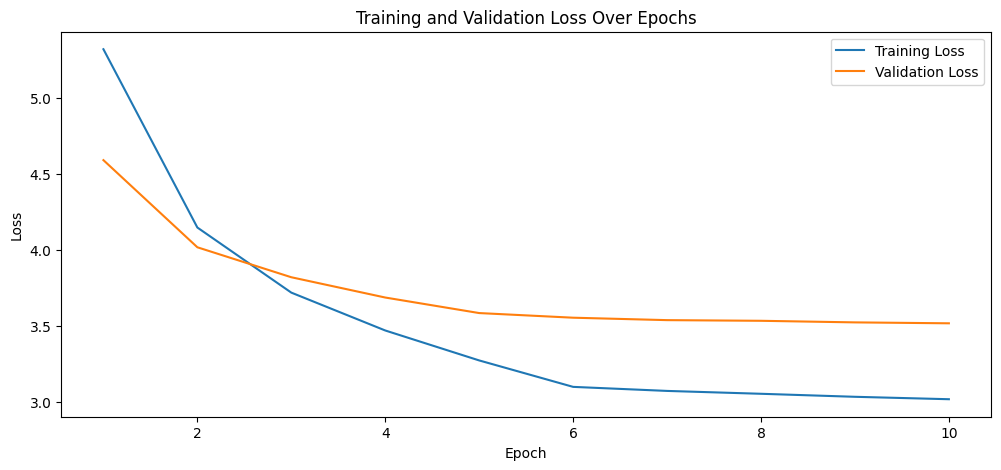

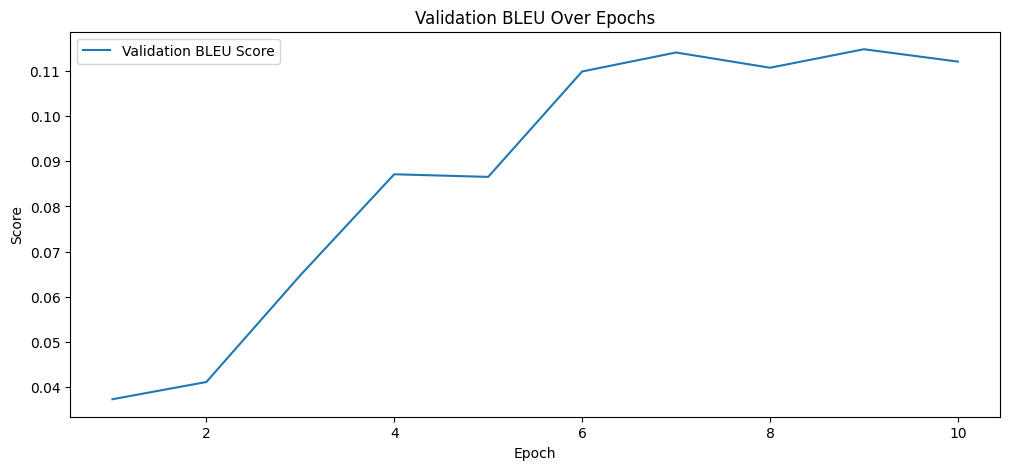

In [51]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plotting BLEU 
plt.figure(figsize=(12, 5))
plt.plot(epochs, val_bleu_scores, label='Validation BLEU Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation BLEU Over Epochs')
plt.legend()
plt.show()


# Testing the Model On Test Dataset

In [58]:
def generate_caption(encoder, decoder,image,max_length=20, beam_width=3):
    """
    Generate image caption using beam search.
    """
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        # Prepare image and extract features
        image = image.to(device).unsqueeze(0)
        features = encoder(image)
        
        # Initialize beam search
        start_idx = word2idx['<start>']
        end_idx = word2idx['<end>']
        
        # Initialize the first beam with <start> token
        # Each beam contains: (cumulative log prob, sequence, hidden state, cell state)
        hidden, cell = decoder.init_hidden_cell(1, device)
        beams = [(0.0, [start_idx], hidden, cell)]
        
        # Beam search
        for _ in range(max_length):
            candidates = []
            
            # Expand each current beam
            for cum_log_prob, sequence, hidden, cell in beams:
                # If the sequence ended, keep it as a candidate
                if sequence[-1] == end_idx:
                    candidates.append((cum_log_prob, sequence, hidden, cell))
                    continue
                
                # Forward pass through decoder
                inputs = torch.tensor([[sequence[-1]]], dtype=torch.long).to(device)
                outputs, new_hidden, new_cell = decoder(inputs, features, hidden, cell)
                outputs = outputs.reshape(outputs.size(0), -1)
                
                # Get log probabilities
                log_probs = torch.log_softmax(outputs, dim=-1)
                
                # Get top-k words
                top_log_probs, top_idx = log_probs.topk(beam_width)
                
                # Create new candidates
                for i in range(beam_width):
                    word_idx = top_idx[0][i].item()
                    log_prob = top_log_probs[0][i].item()
                    candidates.append((
                        cum_log_prob + log_prob,
                        sequence + [word_idx],
                        new_hidden,
                        new_cell
                    ))
            
            # Select top-k beams for next iteration
            candidates.sort(key=lambda x: x[0], reverse=True)
            beams = candidates[:beam_width]
            
            # If all beams ended with <end>, stop
            if all(b[1][-1] == end_idx for b in beams):
                break
        
        # Select the best sequence
        best_sequence = max(beams, key=lambda x: x[0])[1]
        
        # Convert word IDs to words, excluding special tokens
        caption = [idx2word.get(idx, '<unk>') for idx in best_sequence 
                  if idx not in [word2idx['<start>'], word2idx['<end>'], word2idx['<pad>']]]
    
    return ' '.join(caption)

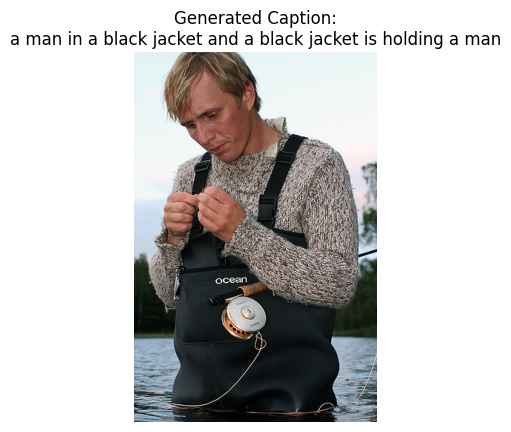

In [59]:
sample_image_name = test_images[0]  
# Construct the full image path
image_path = os.path.join(image_dir, sample_image_name)
# Open the image and convert it to RGB
image = Image.open(image_path).convert('RGB')
# Apply the same transformations used during training
image_tensor = transform(image)

# Generate caption for the sample image
caption = generate_caption(encoder, decoder, image_tensor)

# Display the image and the generated caption
plt.imshow(image)
plt.axis('off')  # Hide axis ticks and labels
plt.title('Generated Caption:\n' + caption)
plt.show()

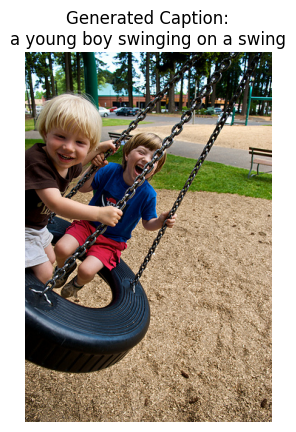

In [60]:
sample_image_name = test_images[33]  
# Construct the full image path
image_path = os.path.join(image_dir, sample_image_name)
# Open the image and convert it to RGB
image = Image.open(image_path).convert('RGB')
# Apply the same transformations used during training
image_tensor = transform(image)

# Generate caption for the sample image
caption = generate_caption(encoder, decoder, image_tensor)

# Display the image and the generated caption
plt.imshow(image)
plt.axis('off')  # Hide axis ticks and labels
plt.title('Generated Caption:\n' + caption)
plt.show()

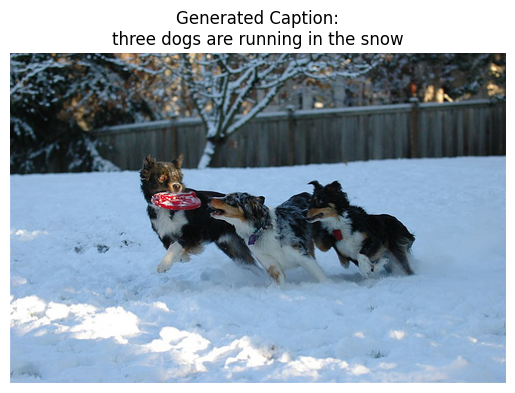

In [55]:
sample_image_name = test_images[90]  
# Construct the full image path
image_path = os.path.join(image_dir, sample_image_name)
# Open the image and convert it to RGB
image = Image.open(image_path).convert('RGB')
# Apply the same transformations used during training
image_tensor = transform(image)

# Generate caption for the sample image
caption = generate_caption(encoder, decoder, image_tensor)

# Display the image and the generated caption
plt.imshow(image)
plt.axis('off')  # Hide axis ticks and labels
plt.title('Generated Caption:\n' + caption)
plt.show()

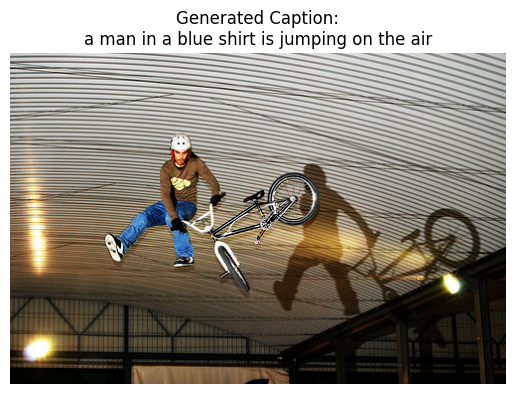

In [56]:
sample_image_name = test_images[4]  
# Construct the full image path
image_path = os.path.join(image_dir, sample_image_name)
# Open the image and convert it to RGB
image = Image.open(image_path).convert('RGB')
# Apply the same transformations used during training
image_tensor = transform(image)

# Generate caption for the sample image
caption = generate_caption(encoder, decoder, image_tensor)

# Display the image and the generated caption
plt.imshow(image)
plt.axis('off')  # Hide axis ticks and labels
plt.title('Generated Caption:\n' + caption)
plt.show()

In [61]:
bleu_score_test = calculate_bleu_score(
    encoder, decoder, image_dir, test_images, test_image2captions, transform
)
print("Bleu Score for the test data : ",round(bleu_score_test,2))

Bleu Score for the test data :  0.12
